In [1]:
# packages
import sys
sys.path.append('../src/emnets/')
import numpy as np 
import torch as th 
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from Emulator import EmulatorNet
from simulator import gaussian_simulator
from active_learning import SNLE_ensemble

# set seed for reproducability
np.random.seed(10)
th.manual_seed(10)

In [2]:
th.cuda.is_available()

False

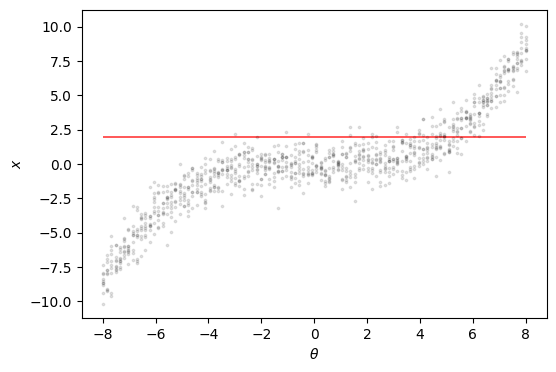

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))

for theta in np.linspace(-8, 8, 100):
    x = gaussian_simulator(theta, n=10)
    ax.scatter(theta.repeat(len(x)), x, c='black', alpha=.1, s=3)
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$x$')

    plt.plot([-8, 8],[2, 2], color='red', linewidth=.1, alpha=.1)

plt.show()

In [4]:
from train import train_network
# sample initial dataset
x_obs = np.array([2])
prior = Uniform(-8, 8)

# construct training set 
train_size = 10000
train_batch_size = 50
theta_init_train = th.Tensor(prior.sample(sample_shape=(train_size,)))
x_init_train = th.Tensor(np.array([gaussian_simulator(t) for t in theta_init_train]).squeeze())
trainset = data.TensorDataset(theta_init_train.unsqueeze(-1), x_init_train)
trainloader = data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

# construct validation set 
valid_size = 100
theta_init_valid = th.Tensor(prior.sample(sample_shape=(valid_size,)))
x_init_valid = th.Tensor(np.array([gaussian_simulator(t) for t in theta_init_valid]).squeeze())
#validset = data.TensorDataset(theta_init_valid.unsqueeze(-1), x_init_valid)
#validloader = data.DataLoader(validset, batch_size=5, shuffle=True)
validset = (theta_init_valid, x_init_valid)

# number of samples 10000
# batch size 100
# epochs 500
# it seems like batch size should be 1/5 number of epochs
n_epochs = 250
valid_rate = 10
emulator = EmulatorNet()
optimizer = th.optim.Adam(emulator.parameters(), lr=0.01)
train_loss, valid_loss = train_network(emulator, optimizer, trainloader, validset, epochs=n_epochs, verbose=False)

100%|█████████████████████████████████████████████████████████| 250/250 [00:18<00:00, 13.22it/s]


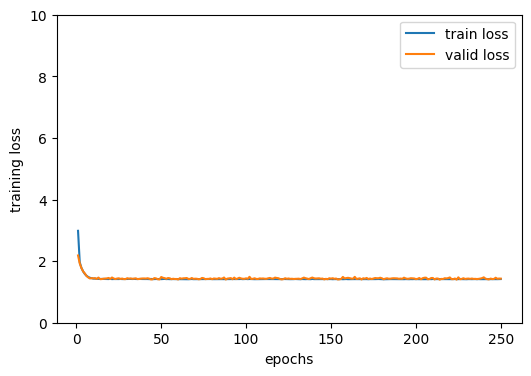

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(train_loss[:,0], train_loss[:,1], label='train loss')
ax.plot(valid_loss[:,0], valid_loss[:,1], label='valid loss')

ax.set_xlabel('epochs')
ax.set_ylabel('training loss')

ax.set_ylim(0, 10)

plt.legend()
plt.show()

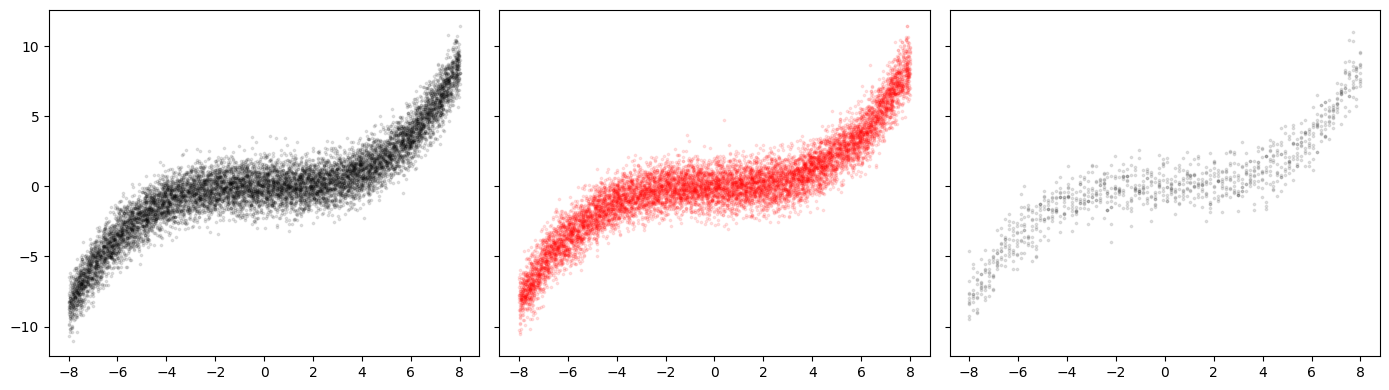

In [6]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=3, sharex=True, sharey=True)
ax[0].scatter(theta_init_train, x_init_train, c='black', alpha=.1, s=3)

predictions=[]
for theta in theta_init_train:
    x_pred = emulator(theta.unsqueeze(-1)).sample()
    predictions.append(x_pred)

ax[1].scatter(theta_init_train, predictions, c='red', alpha=.1, s=3)

n_samples = 10 
for theta in th.linspace(-8, 8, 100):
    dist = emulator(theta.unsqueeze(-1))
    samples = dist.sample((n_samples,))
    ax[2].scatter(theta.repeat(n_samples), samples, c='black', alpha=.1, s=3)

plt.tight_layout()
plt.show()

In [10]:
# define parameters for training 
training_parameters = {
    'x_obs': th.Tensor([2]),
    'prior': Uniform(-8, 8),
    'n_rounds': 5,
    'n_emulators': 3,
    'train_size': 500,
    'valid_size': 100,
    'train_batch_size': 50,
    'train_n_epochs': 250,
    'al_n_samples': 50,
    'al_batch_size': 10,
    'al_n_epochs': 100,
    'lr': .01
}

ensemble, init_train_loss, al_train_loss, all_likelihoods = snle_ensemble(*training_parameters.values())

training initial ensemble...


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


initial training complete!

running active learning loop...


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


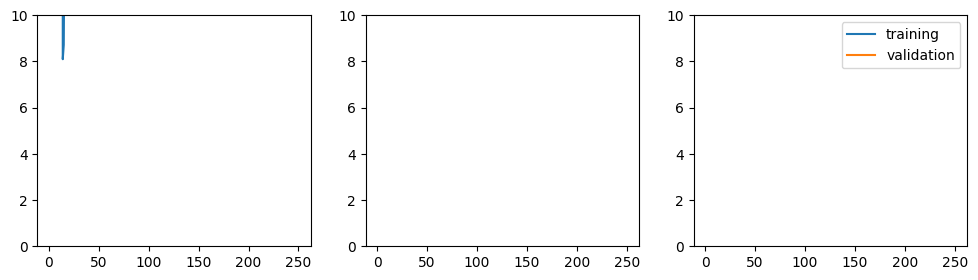

In [11]:
fig, ax = plt.subplots(figsize=(12,3), ncols=3)

for i in range(3):
    ax[i].plot(init_train_loss[i][0][:,0], init_train_loss[i][0][:,1], label='training')
    ax[i].plot(init_train_loss[i][1][:,0], init_train_loss[i][1][:,1], label='validation')
    ax[i].set_ylim(0, 10)
plt.legend()
plt.show()

In [10]:
# define parameters for training 
training_parameters = {
    'x_obs': th.Tensor([2]),
    'prior': Uniform(-8, 8),
    'n_rounds': 10,
    'n_emulators': 3,
    'train_size': 1000,
    'valid_size': 100,
    'train_batch_size': 50,
    'train_n_epochs': 250,
    'al_n_samples': 50,
    'al_batch_size': 25,
    'al_n_epochs': 100,
    'lr': .01
}

ensemble, init_train_loss, al_train_loss, all_likelihoods = snle_ensemble(*training_parameters.values())

training initial ensemble...


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:09<00:00,  3.33s/it]


initial training complete!

running active learning loop...


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


In [12]:
def get_loss(eid, train_loss):
    train_loss = []
    valid_loss = []
    for round in range(len(al_train_loss)):
        train_loss.append(al_train_loss[round][eid][0])
        valid_loss.append(al_train_loss[round][eid][1])
    return np.array(train_loss), np.array(valid_loss)


In [13]:
al_train_loss

[[(array([[  1.        , 492.85928345,  24.84203529],
          [  2.        , 468.82794189,  15.16223621],
          [  3.        , 435.17462158,  15.52969933],
          [  4.        , 401.05123901,  16.26937485],
          [  5.        , 369.87664795,  13.4219656 ],
          [  6.        , 343.73278809,  18.23679924],
          [  7.        , 321.63876343,  29.34437943],
          [  8.        , 302.47094727,   9.20293427],
          [  9.        , 286.63656616,  13.97616768],
          [ 10.        , 273.09411621,  16.69951248],
          [ 11.        , 261.32098389,  10.64483929],
          [ 12.        , 251.05436707,  11.57968044],
          [ 13.        , 242.02189636,   8.73888016],
          [ 14.        , 233.95303345,   4.89603329],
          [ 15.        , 226.79647827,  17.55140305],
          [ 16.        , 220.18179321,  13.85156536],
          [ 17.        , 214.22892761,  12.62720394],
          [ 18.        , 208.64506531,   9.5657196 ],
          [ 19.        , 203

IndexError: index 5 is out of bounds for axis 0 with size 5

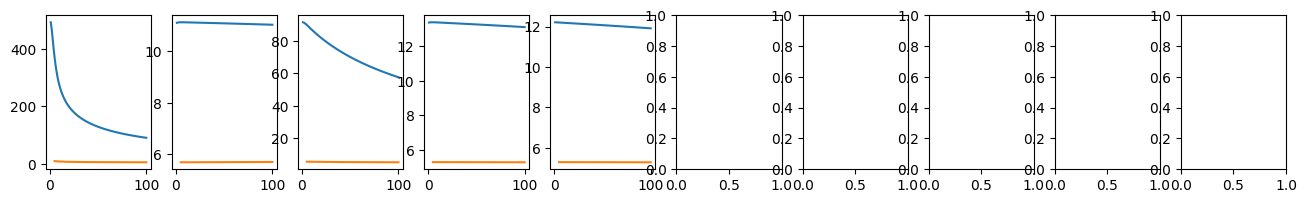

In [14]:
eid = 0
tl, vl = get_loss(eid, al_train_loss)

n_rounds = 10
fig, ax = plt.subplots(figsize=(16, 2), ncols=n_rounds)

for i in range(n_rounds):
    ax[i].plot(tl[i][:,0], tl[i][:,1]) 
    ax[i].plot(vl[i][:,0], vl[i][:,1]) 
    #ax[i].set_ylim((0, 10))

plt.tight_layout()
plt.show()

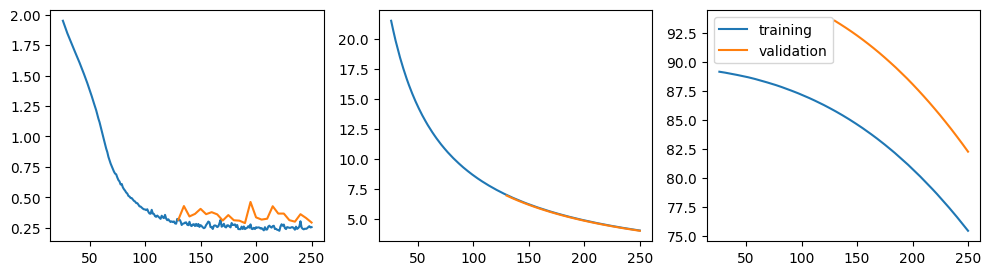

In [17]:
fig, ax = plt.subplots(figsize=(12,3), ncols=3)

for i in range(3):
    ax[i].plot(ensemble_loss[i][0][:,0][25:], ensemble_loss[i][0][:,1][25:], label='training')
    ax[i].plot(ensemble_loss[i][1][:,0][25:], ensemble_loss[i][1][:,1][25:], label='validation')
plt.legend()
plt.show()

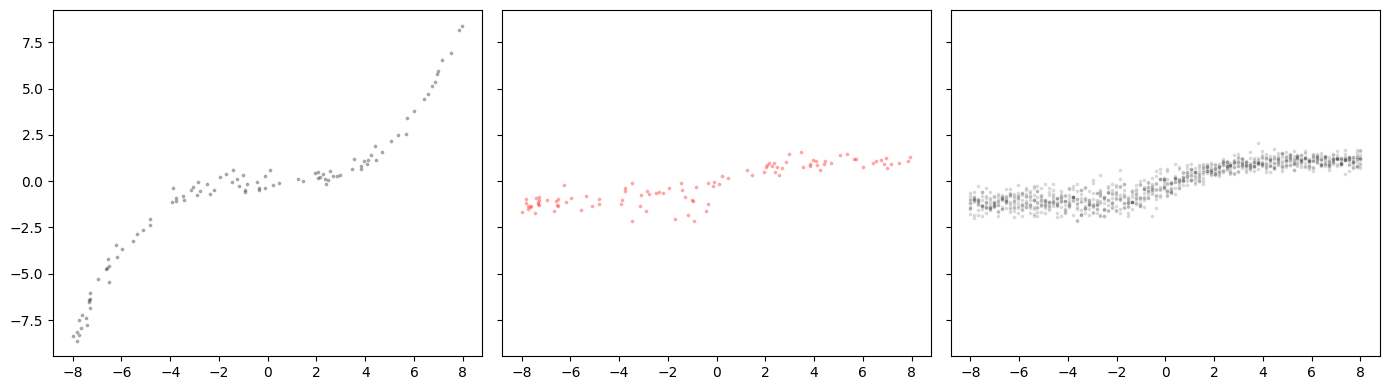

In [17]:
# sample initial dataset
x_obs = np.array([2])
prior = Uniform(-8, 8)

# construct training set 
train_size = 100
theta_init_train = th.Tensor(prior.sample(sample_shape=(train_size,)))
x_init_train = th.Tensor(np.array([gaussian_simulator(t) for t in theta_init_train]).squeeze())
trainset = data.TensorDataset(theta_init_train.unsqueeze(-1), x_init_train)
trainloader = data.DataLoader(trainset, batch_size=50, shuffle=True)

# construct validation set 
valid_size = 10
theta_init_valid = th.Tensor(prior.sample(sample_shape=(valid_size,)))
x_init_valid = th.Tensor(np.array([gaussian_simulator(t) for t in theta_init_valid]).squeeze())
validset = data.TensorDataset(theta_init_valid.unsqueeze(-1), x_init_valid)
validloader = data.DataLoader(validset, batch_size=5, shuffle=True)


# number of samples 10000
# batch size 100
# epochs 500
# it seems like batch size should be 1/5 number of epochs
n_epochs = 550
net, train_loss, valid_loss = train_network(trainloader, validloader, epochs=n_epochs, validation_rate=1, verbose=False)

fig, ax = plt.subplots(figsize=(14, 4), ncols=3, sharex=True, sharey=True)
ax[0].scatter(theta_init_train, x_init_train, c='black', alpha=.25, s=3)

predictions=[]
for theta in theta_init_train:
    x_pred = net(theta.unsqueeze(-1)).sample()
    predictions.append(x_pred)

ax[1].scatter(theta_init_train, predictions, c='red', alpha=.25, s=3)

n_samples = 10 
for theta in th.linspace(-8, 8, 100):
    dist = net(theta.unsqueeze(-1))
    samples = dist.sample((n_samples,))
    ax[2].scatter(theta.repeat(n_samples), samples, c='black', alpha=.1, s=3)

plt.tight_layout()
plt.show()

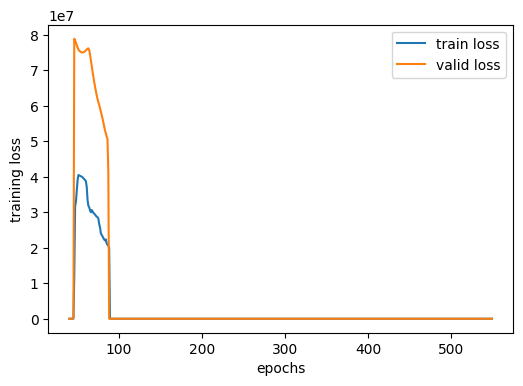

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

t = 40
ax.plot(np.arange(0, n_epochs)[t:], train_loss[t:], label='train loss')
ax.plot(np.arange(0, n_epochs)[t:], valid_loss[t:], label='valid loss')

ax.set_xlabel('epochs')
ax.set_ylabel('training loss')

plt.legend()
plt.show()

In [12]:
def create_dataloader(theta, x, batch_size=1):
    trainset = data.TensorDataset(theta.unsqueeze(-1), x)
    dataloader = data.DataLoader(trainset, batch_size=2, shuffle=True)
    return dataloader

In [13]:
# define obs & prior
x_obs = th.Tensor([2])
prior = Uniform(-8, 8)

# sample initial dataset
init_dataset_size = 50 
theta_train = th.Tensor(prior.sample(sample_shape=(init_dataset_size,)))
x_train = th.Tensor(np.array([gaussian_simulator(t) for t in theta_train]).squeeze())

## training configuration
n_rounds = 10
n_samples = 15
n_emulators = 10
batch_size = 5
n_epochs = 500

## training loop 
all_likelihoods = []
for _ in trange(n_rounds):
    # train ensembles
    ensemble, likelihood_matrix = [], []
    trainloader = create_dataloader(theta_train, x_train, batch_size=batch_size)
    for _ in range(n_emulators):
        ## do we want to retrain the entire newtork??
        network,_ = train_network(trainloader, epochs=n_epochs, verbose=False)
        ## do we want to use theta_train here??
        probs = network(theta_train.unsqueeze(-1)).log_prob(x_obs)
        ensemble.append(network)
        likelihood_matrix.append(probs.detach().numpy())
    
    likelihood_matrix = np.array(likelihood_matrix)
    index = np.argmax(likelihood_matrix.var(axis=0))
    theta_new = theta_train[index]
    x_new = th.Tensor(np.array([gaussian_simulator(theta_new, n=n_samples)]).squeeze())
    x_train = th.concat([x_train, x_new])
    theta_train = th.concat([theta_train, theta_new.repeat(n_samples)])
    all_likelihoods.append(likelihood_matrix)


  0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
x_pred = np.array([net(theta.unsqueeze(-1)).sample() for net in ensemble])
x_pred

array([], dtype=float64)

/var/folders/f3/d5xwhmfs3tz1mx_rvf_24qb80000gn/T/ipykernel_93170/3614149716.py:6: RuntimeWarning: Mean of empty slice.
  x_pred = np.array([net(theta.unsqueeze(-1)).sample() for net in ensemble]).mean()
/Users/hayden/Desktop/code/research/goncalves-lab/emulator-networks/venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


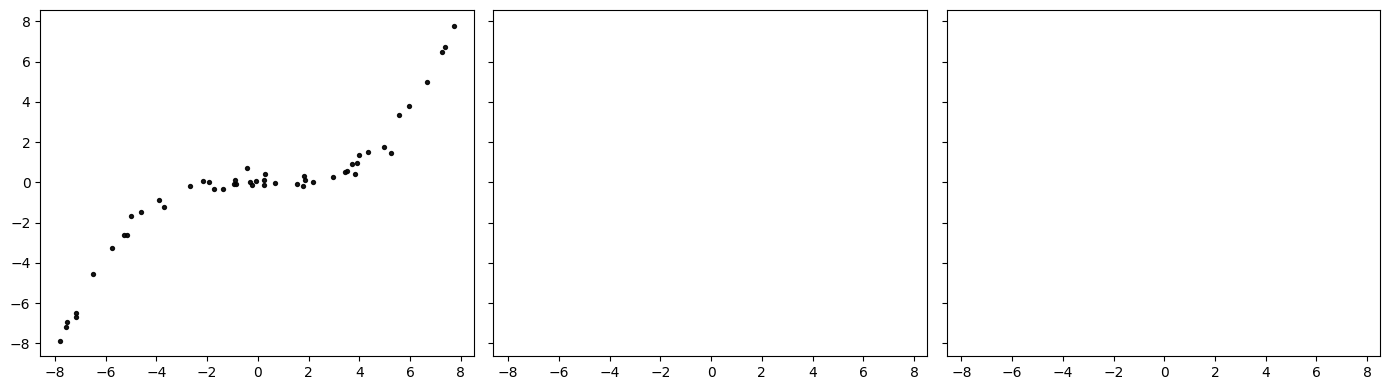

In [33]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=3, sharex=True, sharey=True)
ax[0].scatter(theta_train, x_train, c='black', alpha=.9, s=8)

predictions=[]
for theta in theta_train:
    x_pred = np.array([net(theta.unsqueeze(-1)).sample() for net in ensemble]).mean()
    predictions.append(x_pred)

ax[1].scatter(theta_train, predictions, c='red', alpha=.9, s=8)

#n_samples = 10 
#for theta in th.linspace(-8, 8, 100):
#    dist = net(theta.unsqueeze(-1))
#    samples = dist.sample((n_samples,))
#    ax[2].scatter(theta.repeat(n_samples), samples, c='black', alpha=.1, s=3)

plt.tight_layout()
plt.show()

In [ ]:
theta_train[50:]

tensor([-7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.84

In [105]:
theta_train

tensor([ 1.0599,  3.5632, -3.1460, -2.7165, -3.8464,  6.5631, -0.5379, -7.2056,
        -2.4019, -4.9219, -0.6433, -6.5773,  2.7297, -7.2965, -3.3913,  3.7260,
         6.5631,  6.5631,  6.5631,  6.5631,  6.5631, -7.2965, -7.2965, -7.2965,
        -7.2965, -7.2965, -7.2965, -7.2965, -7.2965, -7.2965, -7.2965])

In [73]:
x_init.shape

torch.Size([100])

In [62]:
likelihood_matrix

array([[ -2.1299834 ,  -0.8473271 ,  -1.6636041 , -14.576711  ,
         -1.709496  ],
       [ -1.523133  ,  -1.0736566 ,  -1.2696104 ,  -8.71239   ,
         -1.4741366 ],
       [ -1.8646313 ,  -3.7948413 ,  -6.100678  , -14.803821  ,
         -1.0899975 ],
       [ -6.2606826 ,  -3.3634796 ,  -1.6947815 ,  -5.5951557 ,
         -5.780322  ],
       [-22.690918  ,  -1.1508148 ,  -2.524095  , -14.456966  ,
         -8.928452  ],
       [ -2.4616642 ,  -2.284924  ,  -2.22599   ,  -1.859093  ,
         -2.4086308 ],
       [ -5.002359  ,  -7.778093  , -10.236049  , -51.697     ,
         -5.685643  ],
       [ -5.2496805 ,  -0.77612054,  -3.3935266 , -13.831925  ,
         -3.4534955 ],
       [ -1.1756358 ,  -1.0126405 ,  -1.7089267 , -12.29371   ,
         -1.0899364 ],
       [ -1.5615206 ,  -1.7569649 ,  -2.1790757 ,  -4.1942816 ,
         -1.6126667 ]], dtype=float32)

<Axes: >

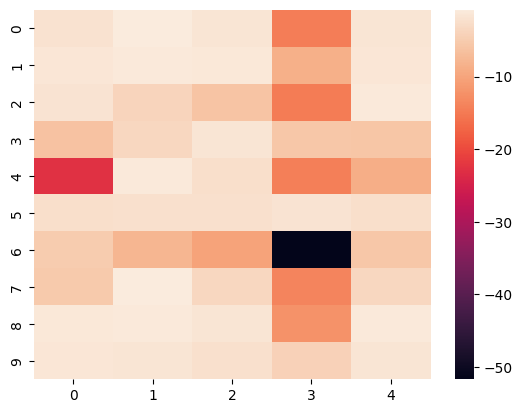

In [65]:
import seaborn as sns

sns.heatmap(likelihood_matrix)

In [24]:
index = np.argmax(likelihood_matrix.var(axis=0))
theta[index]

tensor(-4.7380)